In [1]:
import pandas as pd

ds = pd.read_csv("path/to/malicious_phish.csv")
ds.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [2]:
ds = ds.sample(n=10000)

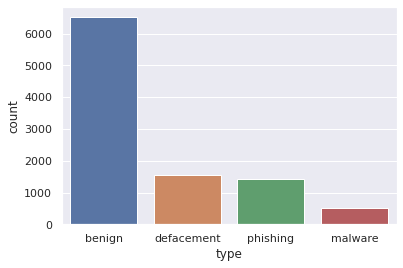

In [3]:
import seaborn as sns
sns.set()
sns.countplot(x="type", data=ds)

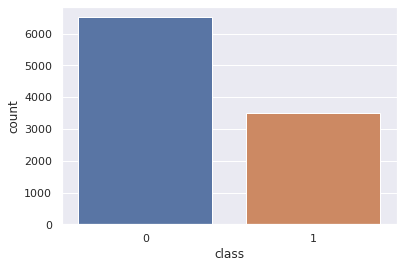

In [4]:
type_mapper = {
    "benign": 0,
    "phishing": 1,
    "defacement": 1,
    "malware": 1,
}
ds["class"] = ds["type"].map(type_mapper)
sns.countplot(x="class", data=ds)

In [5]:
from sklearn.model_selection import train_test_split

X = ds[["url"]]
y = ds["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature extraction

In [6]:
from misc import UrlFeatureExtractor


In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

from misc import UrlFeatureExtractor, to_array


pipe = Pipeline([
    ("url_extractor", UrlFeatureExtractor()),
    ("vectorizer", ColumnTransformer([
        ("scheme", OneHotEncoder(), ["scheme"]),
        ("netloc", make_pipeline(CountVectorizer(analyzer="char"), 
                                FunctionTransformer(to_array)), "netloc"),
        ("path", make_pipeline(CountVectorizer(analyzer="char"), 
                            FunctionTransformer(to_array)), "path"),
        ("passthrough", "passthrough", [
            "len", 
            "is_ip",
            "domain_level",
            "domain_len",
            "has_port",
            "path_level",
            "path_len",
            "num_query_params",
            "query_len",
            "count_%",
        ]),
    ])),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42)),
]).fit(X_train, y_train)

In [8]:
y_pred_proba = pipe.predict_proba(X_test)

In [9]:
# from sklearn.metrics import RocCurveDisplay

# display = RocCurveDisplay.from_predictions(y_test, y_pred_proba[:, 1])
# display.ax_.set_ylim((0.5, 1.05))
# display.ax_.set_xscale("log")



In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1312
           1       0.97      0.92      0.95       688

    accuracy                           0.96      2000
   macro avg       0.97      0.96      0.96      2000
weighted avg       0.97      0.96      0.96      2000



In [11]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(pipe, f)
